# <center>Challenge Data n°2</center>
# <center>DataImmo</center>

Ce notebook est une proposition de solution pour la partie DataScience du Challenge Data D&A. Dans ce challenge, nous représentons un employé de Intel'Immo qui a été chargé de réaliser des analyses prédictives de valeur fonciere à partir d'une base de données immobilières françaises. L'objectif étant ensuite d'effectuer quelques visualisations des valeurs foncières et des surfaces moyennes des logements à l'échelle métropolitaine.

## 1) Imports

Durant l'exécution de ce notebook, il est apparu à plusieurs reprises qu'un notebook ouvert avec Anaconda était plus apte à traiter les modules de carte pour python qu'un autre notebook ouvert avec un terminal powershell par exemple. Ainsi, pour éviter certains problèmes d'importations, je vous invite à redémarrer ce notebook avec anaconda si ce n'était pas le cas. Si anaconda n'est pas installé sur votre ordinateur, décommentez la prochaine cellule.

In [1]:
# %pip install --upgrade pip
# %pip install numpy pandas seaborn scipy sklearn folium

In [2]:
# import des différents modules nécessaires à notre étude
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats

import sklearn
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_percentage_error

from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import folium

## 2) Découverte du dataset et premières manipulations

Dans ce challenge, on nous propose un dataset de vente immobilière pour lequel il manque quelques données de valeur foncière. Il y a deux réponses à donner à l'aide de ce dataset :

- **Prédire les données manquantes pour la variable valeur fonciere**
- **Afficher la valeur fonciere et la surface par région/département**

La première chose à faire est donc d'importer ce dataset et de faire un tri : 
- sur les colonnes à utiliser, car certaines variables ne sont pas forcément nécessaires
- sur les lignes, car il faut peut-être filtrer certaines valeurs
- sur le tableau en général, pour effectuer de potentielles mises à l'échelle

Cette première étape (indispensable) est qualifée de preprocessing.

In [3]:
raw_df=pd.read_excel('Data.xlsx')
raw_df

C:\Users\nicolas.petitmangin\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Date mutation,Nature mutation,Valeur fonciere,No voie,Code type de voie,Type de voie,Code voie,Voie,Code ID commune,Code postal,...,Surface Carrez du 1er lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,2020-02-03,Vente,56000.0,190.0,0,RUE,5,CENTRALE,0,1370.0,...,50.42,1,2,Appartement,NaN,52,2,NaN,NaN,NaN
1,2020-01-02,Vente,165000.0,347.0,0,RUE,20,DU CHATEAU,1,1170.0,...,48.22,2,2,Appartement,NaN,48,3,NaN,NaN,NaN
2,2020-01-08,Vente,720000.0,58.0,1,AV,527,DU MONT BLANC,2,1220.0,...,130.80,2,2,Appartement,NaN,130,6,NaN,NaN,NaN
3,2020-01-06,Vente,429250.0,140.0,0,RUE,2,DE L'ABBE JOLIVET,3,1630.0,...,109.22,1,1,Maison,NaN,109,5,NaN,NaN,NaN
4,2020-01-07,Vente,220900.0,39.0,0,RUE,110,BUFFON,4,1200.0,...,108.65,2,2,Appartement,NaN,91,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34164,2020-06-30,Vente,1290000.0,4.0,0,RUE,8249,DE RIVOLI,3213,75004.0,...,102.09,1,2,Appartement,NaN,99,3,NaN,NaN,NaN
34165,2020-06-30,Vente,726000.0,38.0,0,RUE,9191,DU TEMPLE,3213,75004.0,...,55.95,1,2,Appartement,NaN,56,3,NaN,NaN,NaN
34166,2020-06-25,Vente,420000.0,13.0,0,RUE,9382,DES TOURNELLES,3213,75004.0,...,32.86,2,2,Appartement,NaN,29,2,NaN,NaN,NaN
34167,2020-06-25,Vente,725000.0,16.0,0,RUE,1797,CHARLEMAGNE,3213,75004.0,...,56.80,1,2,Appartement,NaN,48,3,NaN,NaN,NaN


Dans ce challenge, la première partie BI a peut-être déjà pu nous aiguiller sur les features (colonnes) qui étaient intéressantes pour déterminer notre variable à prédire : Valeur fonciere. 

Mais étant donné qu'il n'était pas forcément nécessaire d'avoir réalisé cette première partie, nous allons faire une étude qualitative puis quantitative afin de savoir quelles colonnes sont à conserver et lesquelles sont à omettre.

Il est tout d'abord nécessaire de connaître toutes les colonnes, car certaines ne s'affichent pas ici, le dataframe étant trop large.

In [4]:
raw_df.columns

Index(['Date mutation', 'Nature mutation', 'Valeur fonciere', 'No voie',
       'Code type de voie', 'Type de voie', 'Code voie', 'Voie',
       'Code ID commune', 'Code postal', 'Commune', 'Code departement',
       'Code commune', 'Prefixe de section', 'Section', 'No plan', 'No Volume',
       '1er lot', 'Surface Carrez du 1er lot', 'Nombre de lots',
       'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='object')

On n'a ici affaire qu'à des ventes, la colonne *Nature mutation* va être donc toujours égale à vente et inutile. D'un point de vue géographique, on sait que des données de l'ensemble de la France sont présentes dans ce dataset. Ainsi, il est inutile de s'intéresser aux éléments qui sont trop précis comme *Code voie*, *Voie*, *Commune* ou *Code commune*. Les variables *No voie*, *Code type de voie*, *Type de voie* sont quant à elles tout simplement inutiles. *Nature culture* et *Nature culture spéciale* semblent elles constamment vides. Nous pouvons vérifier cela grâce à la fonction **isnull** qui permet de compter le nombre de cellules vides d'une colonne.

In [4]:
useless_columns=[]
variables=np.array(raw_df.columns)
for v in variables:
    if len(raw_df[raw_df[v].isnull()].index)/len(raw_df[v].index)>0.9:
        useless_columns.append(v)
useless_columns

['Prefixe de section',
 'No Volume',
 'Identifiant local',
 'Nature culture',
 'Nature culture speciale',
 'Surface terrain']

Nous venons de filtrer sur l'ensemble des colonnes qui sont à plus de 90% vides. Nous allons sortir de cette liste *Surface terrain* qui est logiquement relativement vide (car beaucoup de propriétés sont des appartement sans terrain et y ajouter les variables géographiques inutiles mentionnées tout à l'heure. Nous allons également ajouter *Code type local* qui est redondant avec *Type local*. 

In [5]:
useless_columns.remove('Surface terrain')
other_useless_columns=['Nature mutation','No voie','Code type de voie', 'Type de voie', 'Code voie', 'Voie', 'Commune', 'Code commune', 'Code type local']
useless_columns+=other_useless_columns
useless_columns

['Prefixe de section',
 'No Volume',
 'Identifiant local',
 'Nature culture',
 'Nature culture speciale',
 'Nature mutation',
 'No voie',
 'Code type de voie',
 'Type de voie',
 'Code voie',
 'Voie',
 'Commune',
 'Code commune',
 'Code type local']

In [6]:
first_intermediate_df=raw_df.drop(useless_columns,axis=1)
first_intermediate_df['Surface terrain']=first_intermediate_df['Surface terrain'].fillna(0)
first_intermediate_df

,Date mutation,Valeur fonciere,Code ID commune,Code postal,Code departement,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain
0,2020-02-03,56000.0,0,1370.0,1,B,1478,22,50.42,1,Appartement,52,2,0.0
1,2020-01-02,165000.0,1,1170.0,1,A,302,12,48.22,2,Appartement,48,3,0.0
2,2020-01-08,720000.0,2,1220.0,1,AK,563,146,130.80,2,Appartement,130,6,0.0
3,2020-01-06,429250.0,3,1630.0,1,C,2307,11,109.22,1,Maison,109,5,0.0
4,2020-01-07,220900.0,4,1200.0,1,AE,440,31,108.65,2,Appartement,91,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34164,2020-06-30,1290000.0,3213,75004.0,75,AN,3,113,102.09,1,Appartement,99,3,0.0
34165,2020-06-30,726000.0,3213,75004.0,75,AG,79,67,55.95,1,Appartement,56,3,0.0
34166,2020-06-25,420000.0,3213,75004.0,75,AO,73,22,32.86,2,Appartement,29,2,0.0
34167,2020-06-25,725000.0,3213,75004.0,75,AM,67,89,56.80,1,Appartement,48,3,0.0


On rappelle ici que notre variable à prédire est la valeur foncière. Or elle semble ne pas être à la bonne échelle. En effet, on voit que les valeurs sont (naturellement) en milliers mais que la précision s'arrête justement au millier (en moyenne). Il est donc judicieux de diviser cette variable par 1000.

In [7]:
first_intermediate_df['Valeur fonciere']=first_intermediate_df['Valeur fonciere']/1000
first_intermediate_df

,Date mutation,Valeur fonciere,Code ID commune,Code postal,Code departement,Section,No plan,1er lot,Surface Carrez du 1er lot,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain
0,2020-02-03,56.00,0,1370.0,1,B,1478,22,50.42,1,Appartement,52,2,0.0
1,2020-01-02,165.00,1,1170.0,1,A,302,12,48.22,2,Appartement,48,3,0.0
2,2020-01-08,720.00,2,1220.0,1,AK,563,146,130.80,2,Appartement,130,6,0.0
3,2020-01-06,429.25,3,1630.0,1,C,2307,11,109.22,1,Maison,109,5,0.0
4,2020-01-07,220.90,4,1200.0,1,AE,440,31,108.65,2,Appartement,91,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34164,2020-06-30,1290.00,3213,75004.0,75,AN,3,113,102.09,1,Appartement,99,3,0.0
34165,2020-06-30,726.00,3213,75004.0,75,AG,79,67,55.95,1,Appartement,56,3,0.0
34166,2020-06-25,420.00,3213,75004.0,75,AO,73,22,32.86,2,Appartement,29,2,0.0
34167,2020-06-25,725.00,3213,75004.0,75,AM,67,89,56.80,1,Appartement,48,3,0.0


## 3) Etude des corrélations

### A) Méthode de Pearson

On va commencer par utiliser la méthode de corrélation la plus classique, celle de Pearson, qui calcule la force de relation linéaire entre deux variables. La méthode ne permet de calculer la corrélation qu'entre des variables continues (ou supposées continues comme le code postal) mais c'est le cas de la plupart des colonnes de notre dataframe. C'est donc la méthode adaptée pour commencer.

<AxesSubplot:>

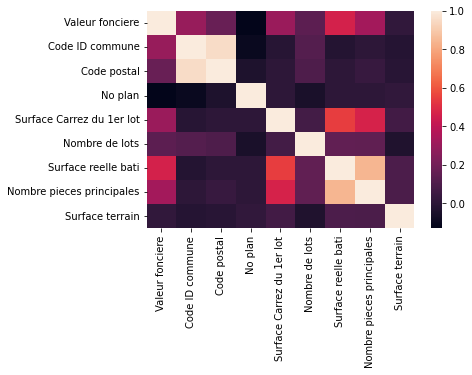

In [9]:
corr_df = first_intermediate_df.corr(method='pearson')
sns.heatmap(corr_df)

On voit que les variables *Code postal* et *Code ID commune* sont (logiquement) très corrélées. On va donc en supprimer une des deux, plutôt *Code postal* car la variable est moins corrélée avec *Valeur fonciere*. De plus, on remarque qu'il n'y a aucune corrélation entre les variables *No plan*, *Nombre de lots* et *Surface terrain* avec *Valeur fonciere*, on va donc également se débarasser de ces colonnes.

In [8]:
second_intermediate_df=first_intermediate_df.drop(['Code postal','No plan','Nombre de lots','Surface terrain'],axis=1)
second_intermediate_df

,Date mutation,Valeur fonciere,Code ID commune,Code departement,Section,1er lot,Surface Carrez du 1er lot,Type local,Surface reelle bati,Nombre pieces principales
0,2020-02-03,56.00,0,1,B,22,50.42,Appartement,52,2
1,2020-01-02,165.00,1,1,A,12,48.22,Appartement,48,3
2,2020-01-08,720.00,2,1,AK,146,130.80,Appartement,130,6
3,2020-01-06,429.25,3,1,C,11,109.22,Maison,109,5
4,2020-01-07,220.90,4,1,AE,31,108.65,Appartement,91,4
...,...,...,...,...,...,...,...,...,...,...
34164,2020-06-30,1290.00,3213,75,AN,113,102.09,Appartement,99,3
34165,2020-06-30,726.00,3213,75,AG,67,55.95,Appartement,56,3
34166,2020-06-25,420.00,3213,75,AO,22,32.86,Appartement,29,2
34167,2020-06-25,725.00,3213,75,AM,89,56.80,Appartement,48,3


### B) Méthode de Spearman

On a trois variable supplémentaires que l'on a vu très corrélées : *Surface Carrez du 1er lot*, *Surface réelle bati* et *Nombre de pieces principales*. Ceci semble logique, mais il est important de ne pas avoir de colonnes redondantes dans notre dataframe, pour éviter l'overfitting. Ainsi, pour faire notre choix entre ces trois colonnes, nous allons utiliser, la méthode de Spearman pour déterminer laquelle a la plus grande corrélation avec la variable *Valeur fonciere*. L'avantage de la méthode de Spearman est qu'elle s'intéresse à la corrélation de fonctions monotones ((dé)croissantes) et pas forcément linéaires. Or, les trois colonnes sont représentatif de la surface du bien et on imagine que le rapport Prix/Surface doit suivre une loi d'une forme (très) à peu près égale à **Prix=a.log(Surface/b)** avec a,b très grands. Ainsi, la corrélation de Spearman est idéale pour déterminer quelle colonne conserver dans notre cas.

In [11]:
scorr_df=second_intermediate_df[['Valeur fonciere','Surface Carrez du 1er lot','Surface reelle bati','Nombre pieces principales']].corr(method='spearman')
scorr_df

,Valeur fonciere,Surface Carrez du 1er lot,Surface reelle bati,Nombre pieces principales
Valeur fonciere,1.000000,0.439176,0.417135,0.381329
Surface Carrez du 1er lot,0.439176,1.000000,0.950789,0.850931
Surface reelle bati,0.417135,0.950789,1.000000,0.876998
Nombre pieces principales,0.381329,0.850931,0.876998,1.000000


<AxesSubplot:>

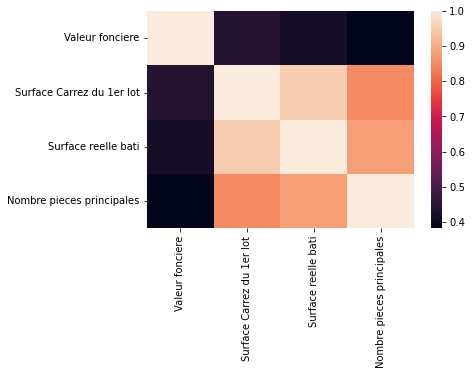

In [12]:
sns.heatmap(scorr_df)

On voit que c'est la colonne *Surface Carrez du 1er lot* qu'il faut conserver dans notre cas car son coeffcient de corrélation avec *Valeur fonciere* est (légèrement) supérieur à celui des deux autres.

In [9]:
third_intermediate_df=second_intermediate_df.copy().drop(['Surface reelle bati','Nombre pieces principales'],axis=1)
third_intermediate_df

,Date mutation,Valeur fonciere,Code ID commune,Code departement,Section,1er lot,Surface Carrez du 1er lot,Type local
0,2020-02-03,56.00,0,1,B,22,50.42,Appartement
1,2020-01-02,165.00,1,1,A,12,48.22,Appartement
2,2020-01-08,720.00,2,1,AK,146,130.80,Appartement
3,2020-01-06,429.25,3,1,C,11,109.22,Maison
4,2020-01-07,220.90,4,1,AE,31,108.65,Appartement
...,...,...,...,...,...,...,...,...
34164,2020-06-30,1290.00,3213,75,AN,113,102.09,Appartement
34165,2020-06-30,726.00,3213,75,AG,67,55.95,Appartement
34166,2020-06-25,420.00,3213,75,AO,22,32.86,Appartement
34167,2020-06-25,725.00,3213,75,AM,89,56.80,Appartement


### C) Méthode du X²

Il y a quelques variables catégorielles dans notre dataset qui n'ont pas encore été testées : *Date mutation*, *Code ID commune*, *Code departement*, *Section* et *Type local*. Il faut donc un nouveau test pour pouvoir les évaluer. Etant catégorielles, le test du X²(chi2) est intéressant pour observer leur corrélation et leur corrélation avec la *Valeur fonciere*. Or, *Valeur fonciere* étant continue, il va falloir la transformer légèrement pour pouvoir lui appliquer la formule du chi2 sans incohérence. C'est le but de la cellule suivante.

In [10]:
def categorisation_valeur_fonciere(df):
    '''
    fonction qui calcule une variable catégorielle à partir de la variable continue Valeur fonciere
    '''
    list_cat=[]
    for i in df :
        if i<100 :
            list_cat.append('A')
        elif 100<=i<250 :
            list_cat.append('B')
        elif 500<=i<1000 :
            list_cat.append('C')
        else :
            list_cat.append('D')
    return list_cat

In [11]:
cat_valeur_fonciere=pd.DataFrame(categorisation_valeur_fonciere(np.array(third_intermediate_df['Valeur fonciere'])))
cat_valeur_fonciere

,0
0,A
1,B
2,C
3,D
4,B
...,...
34164,D
34165,C
34166,D
34167,C


In [12]:
df=third_intermediate_df[['Date mutation','Code ID commune','1er lot','Section','Code departement','Type local']].copy()
df['valeur_fonciere']=cat_valeur_fonciere
df

,Date mutation,Code ID commune,1er lot,Section,Code departement,Type local,valeur_fonciere
0,2020-02-03,0,22,B,1,Appartement,A
1,2020-01-02,1,12,A,1,Appartement,B
2,2020-01-08,2,146,AK,1,Appartement,C
3,2020-01-06,3,11,C,1,Maison,D
4,2020-01-07,4,31,AE,1,Appartement,B
...,...,...,...,...,...,...,...
34164,2020-06-30,3213,113,AN,75,Appartement,D
34165,2020-06-30,3213,67,AG,75,Appartement,C
34166,2020-06-25,3213,22,AO,75,Appartement,D
34167,2020-06-25,3213,89,AM,75,Appartement,C


Nous avons désormais notre dataframe pour appliquer le chi2. Or pandas ne propose pas de module direct pour calculer cette valeur. On peut malgré tout utiliser le module stats de scipy qui comporte la fonction chi2_contingency. Il va donc falloir redéfinir à partir de cela la fonction globale, et c'est le but de la cellule suivante.

In [17]:
factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 
#on définit la liste à parcourir, il s'agit des couples de nos colonnes 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]: #si les colonnes sont différentes, on effectue le calcul grâce au module stats 
        chitest = stats.chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else: #si les colonnes sont égales, on affiche 0 pour ne pas fausser les scores
        chi2.append(0)
        p_values.append(0)

chi2 = np.array(chi2).reshape((7,7)) #on remet le tableau sous forme matricielle
chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # on transforme la matrice en dataframe

<AxesSubplot:>

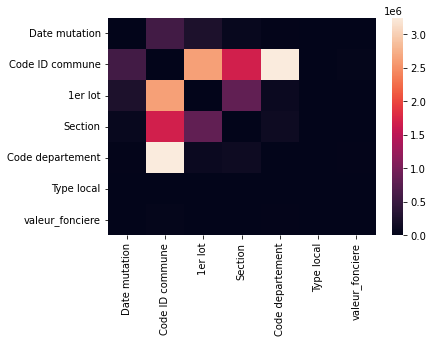

In [18]:
sns.heatmap(chi2)

On remarque une grosse corrélation entre *Code departement*, *Code ID commune*, *1er lot* et *Section* (ce qui est tout à fait logique). Pour le reste, à cause de l'échelle, on ne remarque pas assez bien le niveau de corrélation. On va donc afficher le dataframe.

In [19]:
chi2

,Date mutation,Code ID commune,1er lot,Section,Code departement,Type local,valeur_fonciere
Date mutation,0.000000,5.587111e+05,2.525056e+05,7.581100e+04,2.221763e+04,208.417932,732.036917
Code ID commune,558711.093798,0.000000e+00,2.617823e+06,1.679618e+06,3.246055e+06,11057.876927,28954.602655
1er lot,252505.608848,2.617823e+06,0.000000e+00,8.201402e+05,1.005263e+05,2546.182594,4581.608066
Section,75811.000599,1.679618e+06,8.201402e+05,0.000000e+00,1.183042e+05,903.427008,3972.632340
Code departement,22217.631343,3.246055e+06,1.005263e+05,1.183042e+05,0.000000e+00,1391.974978,17452.889793
Type local,208.417932,1.105788e+04,2.546183e+03,9.034270e+02,1.391975e+03,0.000000,717.695721
valeur_fonciere,732.036917,2.895460e+04,4.581608e+03,3.972632e+03,1.745289e+04,717.695721,0.000000


En plus de la grande corrélation entre *Code departement*, *Section* et *1er lot* avec *Code ID commune*, on remarque ici une très faible corrélation entre les variables *Type local* et *Date mutation* avec *Valeur fonciere*. On va donc se débarasser de ces deux variables. Parmi les trois variables corrélées, *Section* est également très peu corrélée avec *Valeur fonciere*, on va également la supprimer.

In [13]:
df_final=third_intermediate_df.copy().drop(['Date mutation','1er lot','Section','Code departement','Type local'],axis=1)
df_final

,Valeur fonciere,Code ID commune,Surface Carrez du 1er lot
0,56.00,0,50.42
1,165.00,1,48.22
2,720.00,2,130.80
3,429.25,3,109.22
4,220.90,4,108.65
...,...,...,...
34164,1290.00,3213,102.09
34165,726.00,3213,55.95
34166,420.00,3213,32.86
34167,725.00,3213,56.80


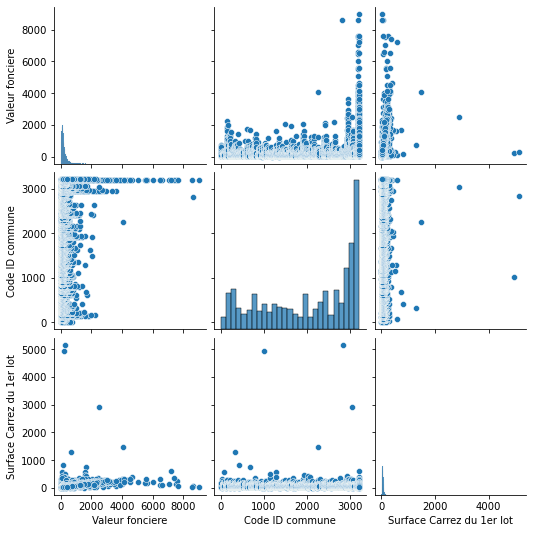

In [21]:
sns.pairplot(df_final)

### D) Supression des valeurs aberrantes

On voit que notre dataframe est composé de valeurs plutôt équiréparties sur la variable *Code ID commune* mais très étalées sur *Valeur fonciere* et *Surface carrez du 1er lot*. Pour éviter de fausser les calculs à cause des outliers, nous allons les retirer de la base de données. Ainsi, nous conservons les lots de minimum 15m² et de valeur 20k€ et au maximum les lots de 250m² et 2M€. Une rapide requête permet de voir que notre base à prédire se situe dans cette limite de superficie.

In [14]:
df_to_map=df_final.copy()
df_final=df_final.loc[(df_final['Surface Carrez du 1er lot'].between(15,250)) & ((df_final['Valeur fonciere'].between(20,2000)) | (df_final['Valeur fonciere'].isnull()))]
df_final.describe()

,Valeur fonciere,Code ID commune,Surface Carrez du 1er lot
count,33147.000000,33165.000000,33165.000000
mean,240.761536,1994.609619,57.239016
std,229.546745,1049.369490,28.402084
min,20.000000,0.000000,15.000000
25%,105.000000,1054.000000,35.610000
50%,170.000000,2272.000000,53.660000
75%,285.525000,2993.000000,72.440000
max,2000.000000,3214.000000,247.540000


## 4) Détermination des valeurs manquantes pour *Valeur fonciere*

Nous avons une grosse base d'entrainement et une petite base de test : ce problème est dit de regression supervisée. Pour le résoudre, nous allons utiliser la librairie scikit-learn et certains des algorithmes qu'elle propose. Nous testerons ces différentes méthodes : **Random Forest**, **XGBoost**, **SVR**, **GLM(Ridge)** et **K-NN**. Nous adapterons ensuite notre algorithme de prédiction en fonction des résultats des différentes données d'entraînement.

### A) Création des base d'entrainement et de test

In [15]:
df_final_train=df_final.loc[df_final['Valeur fonciere']>0]
df_final_test=df_final.loc[df_final['Valeur fonciere'].isnull()]
df_final_test=df_final_test[['Code ID commune', 'Surface Carrez du 1er lot']]

In [16]:
X = df_final_train.loc[:, df_final_train.columns != 'Valeur fonciere']
Y = df_final_train.loc[:, df_final_train.columns == 'Valeur fonciere']

In [17]:
seed = 123
validation_size = 0.20
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

### B) Grid Search et paramétrisation

On va utiliser diverses méthodes pour faire la prédiction des valeurs manquantes pour *Valeur fonciere*. Toutes ces méthodes comportent des paramètres et des hyperparamètres. (Pour en savoir plus sur les hyperparamètres : https://towardsdatascience.com/parameters-and-hyperparameters-aa609601a9ac) Il faut donc choisir ces hyperparamètres soigneusement. Pour ce faire, on va utiliser la gridsearch qui va tester les différentes combinaisons des hyperparamètres et nous renvoyer les plus adaptés à chaque méthode. On pourrait le faire à la main, mais cela demande une grosse connaissance du sujet et de la théorie mathématique sous jacente à chaque méthode, il est donc préférable d'utiliser cette recherche paramétrée.

In [26]:
def display(results):
    """
    Cette fonction "print" tous les résultats (scores) de la grid search et renvoie le dictionnaire des paramètres optimaux
    """
    print(f'Best parameters are: {results.best_params_}') #en haut seront imprimés les meilleurs paramètres
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    #on print quand même les résultats de chaque test, au cas où on préférerait un résultat avec moins de variance par exemple
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}') 

La cellule suivante a été effectuée de nombreuses reprises. En effet, elle comporte les paramètres à tester pour chacun des méthodes. Pour éviter un temps de calcul extrêmement long, il faut donc ratisser large au début puis préciser au fur et à mesure le choix des paramètres autour des meilleures valeurs précedemment obtenus. Pour chaque GridSearch, les résultats (que j'avais trouvé, pas forcément les meilleurs pour votre cross-validation) seront notés dans une celulle commentée en dessous. N'effectuez pas la grid search et décommentez la cellule si vous voulez économisez du temps de calcul.

In [27]:
rf = RandomForestRegressor()
# Hyperparamètres à tester pour la méthode Random Forest
parameters_forest = {"n_estimators":[139,140,141], "max_depth":[20,21]}

rsvr = SVR()
# Hyperparamètres à tester pour la méthode Support Vector Machine
parameters_svr = {"kernel":["poly","rbf"],"epsilon":[0.05,0.1,0.2,0.3]}

rknn = KNeighborsRegressor()
# Hyperparamètres à tester pour la méthode des k plus proches voisins
parameters_knn = {"n_neighbors":[k for k in range(1,30)], "weights":["uniform", "distance"]}

ridge = linear_model.Ridge()
# Hyperparamètres à tester pour la méthode ridge (GLM)
parameters_ridge = {"alpha":[k/2 for k in range (4,10)]}

xgb = GradientBoostingRegressor()
# Hyperparamètres à tester pour la méthode Gradient Boosting (XGBoost)
parameters_xgb = {"learning_rate":[k/100 for k in [17,18,19]],"n_estimators":[90,100,110], "max_depth":[4,5,6]}

### C) Random Forest

Les méthodes *Random Forest* et *XGBoost* sont des méthodes dites d'ensemble, qui utlisent des arbres de décisions. Le but de l'algorithme est donc d'apprendre la topologie associée à l'arbre et les valeurs associées aux différentes feuilles. Or nous faisons face ici à un problème de régression, il ne s'agit pas ici de trouver le chemin optimal sur l'arbre et de renvoyer la valeur associée. L'algorithme cherche donc à quantifier les différences entre chaque branches, en les comparant à l'aide d'une approche gloutonne. Il s'arrête lorsqu'un critère d'arrêt est atteint, d'où l'importance de bien choisir les hyperparamètres qui vont être modifiés.

Parmi les méthodes d'ensemble, on retrouve deux types majoritaires : les méthodes de **Bagging** (pour bootstrap aggregating) et **Boosting**. Random Forest est une méthode de bagging : le but est de "boostrap" : construire de nombreux estimateurs différents indépendants (dont on fait varier le nombre dans notre grid search) puis "aggregate" : moyenner leurs prédictions. Naturellement, cela, conduit à une grande réduction de la variance de notre prédiction, ce qui est d'autant plus utile lorsque l'on utilise la cross-validation comme dans notre cas.

Par rapport à un algorithme de bagging classique, l'avantage de random forest est qu'il permet une construction totalement aléatoires des arbres, ce qui est utile lorsque les features sont (même légèrement) corrélées et permet de réduire encore la variance des prédictions.

Enfin, on n'a ici que deux features donc ce n'est pas forcément le critères le plus adapté ; pour autant, notre preprocessing nous a montré que c'était les critères indispensables et on ne risque également ainsi aucun overfitting.

In [28]:
#On réalise la recherche paramétrique
cv = GridSearchCV(rf,parameters_forest,cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv.fit(X,Y)
display(cv)
#On sauvegarde les paramètres optimaux
n_estimators = cv.best_params_['n_estimators']
max_depth = cv.best_params_['max_depth']

C:\Users\nicolas.petitmangin\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best parameters are: {'max_depth': 20, 'n_estimators': 140}


-0.668 + or -0.227 for the {'max_depth': 20, 'n_estimators': 139}
-0.664 + or -0.222 for the {'max_depth': 20, 'n_estimators': 140}
-0.665 + or -0.22 for the {'max_depth': 20, 'n_estimators': 141}
-0.666 + or -0.224 for the {'max_depth': 21, 'n_estimators': 139}
-0.669 + or -0.227 for the {'max_depth': 21, 'n_estimators': 140}
-0.668 + or -0.226 for the {'max_depth': 21, 'n_estimators': 141}


In [19]:
n_estimators=141
max_depth=21

In [20]:
RF = RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
RF.fit(X_train, y_train)

y_pred = pd.DataFrame(RF.predict(X_test))

y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

result_rf = pd.concat([y_test,y_pred], axis=1)
result_rf = result_rf.set_axis(['actual', 'predict'], axis=1, inplace=False)

#rf_score=RF.score(X_test, y_test)
#rf_score

rf_mape=mean_absolute_percentage_error(y_pred,y_test)
rf_mape

C:\Users\nicolas.petitmangin\AppData\Local\Temp\ipykernel_90104\3345500833.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


0.2615204788137805

### D) SVR

Les **Support Vector Machines** (ou SVM) sont apparues dans les années 90 et sont basées sur la théorie de Vapnik-Chervonenkis, qui est une théorie d'apprentissage statistique extrêmement intéressante permet de comprendre quels sont les enjeux et les méthodes utilisées majoritairement en Machine Learning. En effet, les SVM nous montrent des méthodes de déformation algébrique et de résolution Lagrangienne qui sont réutilisées dans de nombreux autres algorithmes. S'attarder sur la définition et la résolution de problèmes avec les SVM demanderait trop de temps, mais vous pouvez garder en tête qu'elles étaient LA référence en matière d'algorithme prédictif avant l'avènement des réseaux de neurones (qui existaient déjà mais dont l'intérêt était encore incompris).

Un point intéressant est de réfléchir au kernel que l'on va utiliser. Les kernels sont les fonctions qui vont déformer l'espace d'hypothèse et ainsi sont sûrement l'hyperparamètre le plus important à modifier. Il en existe d'ailleurs de nombreux types. Vous pouvez en découvrir plus sur le sujet en suivant le lien suivant : https://dataaspirant.com/svm-kernels/

In [31]:
# Compute grid search
cv = GridSearchCV(rsvr,parameters_svr,cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,verbose=10)
cv.fit(X,Y)
display(cv)
# Save optimal hyperparameters
epsilon = cv.best_params_['epsilon']
kernel = cv.best_params_['kernel']

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\nicolas.petitmangin\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters are: {'epsilon': 0.1, 'kernel': 'poly'}


-0.632 + or -0.172 for the {'epsilon': 0.05, 'kernel': 'poly'}
-0.692 + or -0.105 for the {'epsilon': 0.05, 'kernel': 'rbf'}
-0.632 + or -0.172 for the {'epsilon': 0.1, 'kernel': 'poly'}
-0.692 + or -0.105 for the {'epsilon': 0.1, 'kernel': 'rbf'}
-0.632 + or -0.172 for the {'epsilon': 0.2, 'kernel': 'poly'}
-0.692 + or -0.105 for the {'epsilon': 0.2, 'kernel': 'rbf'}
-0.632 + or -0.172 for the {'epsilon': 0.3, 'kernel': 'poly'}
-0.692 + or -0.106 for the {'epsilon': 0.3, 'kernel': 'rbf'}


In [32]:
epsilon=0.1
kernel='poly'

In [33]:
svr = SVR(epsilon=epsilon, kernel=kernel)
svr.fit(X_train, y_train)

y_pred = pd.DataFrame(svr.predict(X_test))

y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

result_svr = pd.concat([y_test,y_pred], axis=1)
result_svr = result_svr.set_axis(['actual', 'predict'], axis=1, inplace=False)

#svr_score=svr.score(X_test, y_test)
#svr_score
svr_mape=mean_absolute_percentage_error(y_pred,y_test)
svr_mape

C:\Users\nicolas.petitmangin\Anaconda\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6007603024101789

### E) K-NN

De toutes les méthodes utilisées, la méthodes des **k-plus proches voisins** est sûrement la plus simple à comprendre. Pour un élement à prédire, l'algorithme va calculer sa distance avec l'ensemble des éléments du dataset de train, va conserver les valeurs cibles des k éléments les plus "proches" et va en faire la moyenne pour déterminer la valeur cible de l'élément à prédire. Ainsi, les paramètres sur lesquels il faut jouer sont le nombre de voisins et le type de distance à utiliser.

In [34]:
# Compute grid search
cv = GridSearchCV(rknn,parameters_knn,cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv.fit(X,Y)
display(cv)
# Save optimal hyperparameters
n_neighbors = cv.best_params_['n_neighbors']
weights = cv.best_params_['weights']

Best parameters are: {'n_neighbors': 22, 'weights': 'distance'}


-0.713 + or -0.264 for the {'n_neighbors': 1, 'weights': 'uniform'}
-0.713 + or -0.264 for the {'n_neighbors': 1, 'weights': 'distance'}
-0.735 + or -0.345 for the {'n_neighbors': 2, 'weights': 'uniform'}
-0.735 + or -0.345 for the {'n_neighbors': 2, 'weights': 'distance'}
-0.762 + or -0.415 for the {'n_neighbors': 3, 'weights': 'uniform'}
-0.762 + or -0.415 for the {'n_neighbors': 3, 'weights': 'distance'}
-0.788 + or -0.467 for the {'n_neighbors': 4, 'weights': 'uniform'}
-0.788 + or -0.467 for the {'n_neighbors': 4, 'weights': 'distance'}
-0.752 + or -0.4 for the {'n_neighbors': 5, 'weights': 'uniform'}
-0.753 + or -0.402 for the {'n_neighbors': 5, 'weights': 'distance'}
-0.725 + or -0.35 for the {'n_neighbors': 6, 'weights': 'uniform'}
-0.726 + or -0.353 for the {'n_neighbors': 6, 'weights': 'distance'}
-0.708 + or -0.321 for the {'n_neighbors': 7, 'weights': 'uniform'}
-0.709 + or -0.323 for the {'n_neighbors': 7, '

In [21]:
n_neighbors=22
weights='distance'

In [22]:
rknn = KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights)
rknn.fit(X_train, y_train)

y_pred = pd.DataFrame(rknn.predict(X_test))

y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

result_knn = pd.concat([y_test,y_pred], axis=1)
result_knn = result_knn.set_axis(['actual', 'predict'], axis=1, inplace=False)

#rknn_score=rknn.score(X_test, y_test)
#rknn_score
rknn_mape=mean_absolute_percentage_error(y_pred,y_test)
rknn_mape

0.2605112340615026

### F) Ridge (Most Used Generalized Linear Models)

Ridge est un modèle linéaire généralisé. Il faut le voir comme une régression linéaire à laquelle on permet quelques libertés supplémentaires, afin d'améliorer la prédiction. Ces méthodes GLM sont souvent malheureusement moins robustes que les boites noires (rf, xgboost, neural networks,...) mais présentent l'avantage d'être totalement transparentes : on a une fonction quasi-linéaire de nos paramètres. Ainsi elles sont facilement explicatives et peuvent aisément être mises à l'échelle, par exemple avec l'ajout d'une variable d'entrée. Elles sont idéales pour des modèles avec beaucoup de paramètres, c'est pourquoi elles sont souvent utilisées dans le secteur des assurances.  

In [37]:
cv = GridSearchCV(ridge,parameters_ridge,cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv.fit(X,Y)
display(cv)
alpha = cv.best_params_['alpha']

Best parameters are: {'alpha': 4.5}


-1.031 + or -0.333 for the {'alpha': 2.0}
-1.031 + or -0.333 for the {'alpha': 2.5}
-1.031 + or -0.333 for the {'alpha': 3.0}
-1.031 + or -0.333 for the {'alpha': 3.5}
-1.031 + or -0.333 for the {'alpha': 4.0}
-1.031 + or -0.333 for the {'alpha': 4.5}


In [38]:
alpha=4.5

In [39]:
reg = linear_model.Ridge(alpha)
reg.fit(X_train, y_train)

y_pred = pd.DataFrame(reg.predict(X_test))

y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

result_ridge = pd.concat([y_test,y_pred], axis=1)
result_ridge = result_ridge.set_axis(['actual', 'predict'], axis=1, inplace=False)

#ridge_score=reg.score(X_test, y_test)
#ridge_score
mean_absolute_percentage_error(y_pred,y_test)

1.5577242878733024

### G) Gradient Boosting (XGBoost)

Nous avons vu dans la session random forest que xgboost est également une méthode d'ensemble. Mais contrairement aux méthodes de bagging comme rf qui additionne des estimateurs de faible biais et forte variance pour réduire la variance, l'algorithme de boosting va additioner séquentiellement des estimateurs faibles à faibles variances pour en faire un estimateur à faible biais et faible variance. Ainsi, on peut le voir comme un arbre de décision où chaque branche représente une décision adaptative par rapport à une variable. 

In [40]:
cv = GridSearchCV(xgb,parameters_xgb,cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv.fit(X,Y)
display(cv)

eta=cv.best_params_['learning_rate']
max_depth_xgb=cv.best_params_['max_depth']
n_estimators_xgb=cv.best_params_['n_estimators']

C:\Users\nicolas.petitmangin\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters are: {'learning_rate': 0.18, 'max_depth': 5, 'n_estimators': 100}


-0.645 + or -0.199 for the {'learning_rate': 0.17, 'max_depth': 4, 'n_estimators': 90}
-0.636 + or -0.189 for the {'learning_rate': 0.17, 'max_depth': 4, 'n_estimators': 100}
-0.639 + or -0.193 for the {'learning_rate': 0.17, 'max_depth': 4, 'n_estimators': 110}
-0.632 + or -0.209 for the {'learning_rate': 0.17, 'max_depth': 5, 'n_estimators': 90}
-0.633 + or -0.209 for the {'learning_rate': 0.17, 'max_depth': 5, 'n_estimators': 100}
-0.636 + or -0.209 for the {'learning_rate': 0.17, 'max_depth': 5, 'n_estimators': 110}
-0.633 + or -0.216 for the {'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 90}
-0.632 + or -0.206 for the {'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 100}
-0.63 + or -0.202 for the {'learning_rate': 0.17, 'max_depth': 6, 'n_estimators': 110}
-0.628 + or -0.172 for the {'learning_rate': 0.18, 'max_depth': 4, 'n_estimators': 90}
-0.627 + or -0.172 for the {'learning_rat

In [23]:
eta=0.18
max_depth_xgb=5
n_estimators_xgb=100

In [24]:
xgb = GradientBoostingRegressor(random_state=0, learning_rate=eta, max_depth=max_depth_xgb, n_estimators= n_estimators_xgb)
xgb.fit(X_train, y_train)
ft_importances = xgb.feature_importances_

y_pred = pd.DataFrame(xgb.predict(X_test))

y_pred.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

result_xgb = pd.concat([y_test,y_pred], axis=1)
result_xgb = result_xgb.set_axis(['actual', 'predict'], axis=1, inplace=False)

#xgb_score=xgb.score(X_test, y_test)
#xgb_score

xgb_mape=mean_absolute_percentage_error(y_pred,y_test)
xgb_mape

C:\Users\nicolas.petitmangin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2664982482936162

### H) Bilan et axes d'amélioration

Nous avons donc les résultats pour les 5 méthodes et trois ressortent du lot. : XGB, RF et K-NN. Nous n'allons donc pas utiliser les résultats de la regression ridge et de la epsilon-SVR. 

Nous allons combiner les méthodes des trois méthodes "gagnantes" et les pondérer par leur score respectif. 

In [25]:
result=pd.concat([result_xgb,result_rf['predict'],result_knn['predict']],axis=1)
result.columns=['real','xgb','rf','rknn']
result['mean_prediction']=(result['xgb']+result['rf']+result['rknn'])/3
score_total=1/xgb_mape+1/rf_mape+1/rknn_mape
result['weighted_prediction']=(1/xgb_mape)/score_total*result['xgb']+(1/rf_mape)/score_total*result['rf']+(1/rknn_mape)/score_total*result['rknn']
result

,real,xgb,rf,rknn,mean_prediction,weighted_prediction
0,52.30,94.178321,68.289674,77.515626,79.994540,79.902575
1,110.00,166.124505,185.013999,176.718780,175.952428,176.014916
2,192.19,161.936841,168.658156,173.506553,168.033850,168.079102
3,170.00,202.051508,162.883729,174.565301,179.833513,179.687657
4,169.35,218.499413,285.595225,266.829597,256.974745,257.228275
...,...,...,...,...,...,...
6625,502.00,505.050358,466.781645,467.161997,479.664667,479.489602
6626,380.00,235.483828,313.735861,214.883358,254.701015,254.769584
6627,82.00,108.133085,106.230179,131.018974,115.127413,115.191800
6628,546.00,520.965429,571.014159,565.101505,552.360364,552.573338


In [44]:
mean_pred_mape=mean_absolute_percentage_error(result['mean_prediction'].tolist(),y_pred)
mean_pred_mape

0.08517581064585132

In [45]:
w_pred_mape=mean_absolute_percentage_error(result['weighted_prediction'].tolist(),y_pred)
w_pred_mape

0.08571736327108317

On avait une erreur relative moyenne d'environ 26% avec nos trois méthodes (avec une paramétrisation presque optimisée). On voit que moyenner les prédictions est une méthode qui fonctionne extrêmement bien également, vu que cette erreur passe, grâce à ce moyennage, vers les 8%. Même si le score pour le moyennage sans pondération est légèrement meilleur, on va faire confiance au moyennage avec pondération pour la prédiction finale.

Pour améliorer ce modèle, on peut s'interroger sur la paramétrisation de la SVM : il aurait été intéressant de tester d'autres kernels avec d'autres paramètres epsilon. Avec un résultat satisfaisant, on aurait alors pu inclure les résultats de la SVR dans le moyennage. Mais le calcul d'une SVR prend bcp de temps, c'est pourquoi il aurait fallu pour cela sampler notre datasets afin d'accélérer les calculs.

Il aurait également été intéressant de tester d'autres méthodes, et potentiellement de combiner une méthode d'apprentissage non supervisé comme les k-means avec une des méthodes utilisées ici.

Enfin, on aurait pu augmenter la taille de la base de données en récoltant sur internet des données pour d'autres périodes, mais le preprocessing aurait été le même, et c'était donc une tâche moins intéressante que le travail sur les paramètres ici, pour un rapport résultat/temps de travail qui aurait été sûrement moins intéressant aussi.
De même, en regardant l'autre dimension (#{variables}), on peut se demander s'il n'aurait pas été plus efficace d'en garder quelques une de plus, notamment pour les méthodes d'ensemble. L'avantage de notre méthode est double :
- **Aucun overfitting**
- **Plus grande transparence**

Passons désormais aux prédictions pour les valeurs manquantes et à l'affichage des données sur la carte de la France.

### H) Prédictions

In [26]:
#On rappelle les modèles que l'on va utiliser
xgb = GradientBoostingRegressor(random_state=0, learning_rate=eta, max_depth=max_depth_xgb, n_estimators= n_estimators_xgb)
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
rknn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)

#On entraine cette fois sur l'ensemble du dataset
xgb.fit(X,Y)
rf.fit(X,Y)
rknn.fit(X,Y)

#Execution des prédictions
predictions_xgb = pd.DataFrame(xgb.predict(df_final_test))
predictions_rf = pd.DataFrame(rf.predict(df_final_test))
predictions_rknn = pd.DataFrame(rknn.predict(df_final_test))

#moyennage
predictions=(1/xgb_mape)/score_total*predictions_xgb+(1/rf_mape)/score_total*predictions_rf+(1/rknn_mape)/score_total*predictions_rknn
predictions

C:\Users\nicolas.petitmangin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nicolas.petitmangin\AppData\Local\Temp\ipykernel_90104\884179510.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X,Y)


,0
0,40.858991
1,180.490065
2,187.252857
3,58.995066
4,69.664630
5,163.253984
6,260.950853
7,74.875276
8,88.359359
9,94.009241


In [27]:
predictions.columns=['Valeur fonciere']
dict_val_manquantes=dict(zip(df_final_test.index.values,predictions['Valeur fonciere'].tolist()))
dict_val_manquantes

{456: 40.85899069542505,
 1569: 180.49006525008141,
 3871: 187.25285689720243,
 4080: 58.995065522294816,
 4867: 69.66462955296026,
 5281: 163.25398407272982,
 10217: 260.95085269840985,
 13564: 74.8752760569289,
 13593: 88.35935872448772,
 16370: 94.00924074490177,
 20795: 141.44561339582276,
 21005: 148.59842021610976,
 25452: 152.69056643194511,
 25531: 177.34930830807423,
 27713: 208.35830862361792,
 29371: 1807.9155562745768,
 31115: 712.6951427513264,
 33935: 262.5749677415693}

In [28]:
df_to_map['Valeur fonciere']=df_to_map['Valeur fonciere'].fillna(dict_val_manquantes)
df_to_map.head(457)

,Valeur fonciere,Code ID commune,Surface Carrez du 1er lot
0,56.000000,0,50.42
1,165.000000,1,48.22
2,720.000000,2,130.80
3,429.250000,3,109.22
4,220.900000,4,108.65
...,...,...,...
452,90.000000,77,67.58
453,75.000000,110,46.78
454,41.500000,111,19.15
455,41.080000,112,23.69


## 5) Représentation cartographique

On va tout d'abord moyenner les variables *Valeur fonciere* et *Surface Carrez du 1er lot* par département.

In [29]:
df_to_map['Departement']=raw_df['Code departement']
df_grouped=df_to_map.groupby(['Departement']).mean()
df_grouped=df_grouped.drop('Code ID commune',axis=1)
df_grouped['Valeur fonciere']=(1000*df_grouped['Valeur fonciere']).astype(int)
df_grouped['Prix/Surface']=(df_grouped['Valeur fonciere']/df_grouped['Surface Carrez du 1er lot']).astype(int)
df_grouped['Surface Carrez du 1er lot']=df_grouped['Surface Carrez du 1er lot'].astype(int)
df_grouped=df_grouped.reset_index()
df_grouped

,Departement,Valeur fonciere,Surface Carrez du 1er lot,Prix/Surface
0,1,230949,75,3040
1,10,89509,61,1458
2,11,96178,42,2278
3,12,138000,67,2033
4,13,166756,58,2864
...,...,...,...,...
91,95,185704,60,3051
92,971,69500,23,2946
93,972,150057,57,2621
94,973,133984,53,2482


In [30]:
df_departement=pd.read_excel('contours_departements.xlsx')
df_departement

,Lat,Lon,code_insee,nom
0,46.099799,5.348764,1,Ain
1,48.304634,4.161448,10,Aube
2,43.103254,2.413622,11,Aude
3,44.281103,2.678577,12,Aveyron
4,43.543055,5.086225,13,Bouches-du-Rhône
...,...,...,...,...
91,49.082758,2.130873,95,Val-d'Oise
92,16.197587,-61.539823,971,Guadeloupe
93,14.654532,-61.018928,972,Martinique
94,3.922325,-53.239168,973,Guyane


In [31]:
df_grouped['Lat']=df_departement['Lat']
df_grouped['Lon']=df_departement['Lon']
df_grouped['Nom_departement']=df_departement['nom']
df_grouped

,Departement,Valeur fonciere,Surface Carrez du 1er lot,Prix/Surface,Lat,Lon,Nom_departement
0,1,230949,75,3040,46.099799,5.348764,Ain
1,10,89509,61,1458,48.304634,4.161448,Aube
2,11,96178,42,2278,43.103254,2.413622,Aude
3,12,138000,67,2033,44.281103,2.678577,Aveyron
4,13,166756,58,2864,43.543055,5.086225,Bouches-du-Rhône
...,...,...,...,...,...,...,...
91,95,185704,60,3051,49.082758,2.130873,Val-d'Oise
92,971,69500,23,2946,16.197587,-61.539823,Guadeloupe
93,972,150057,57,2621,14.654532,-61.018928,Martinique
94,973,133984,53,2482,3.922325,-53.239168,Guyane


In [35]:
df_grouped.to_csv('df_tableau.csv')

In [32]:
carte= folium.Map(location=[43.634, 1.433333],zoom_start=6)
lat=df_grouped['Lat'].tolist()
lon=df_grouped['Lon'].tolist()
lat_lon=[]
for i in range(len(lat)):
    lat_lon.append([lat[i],lon[i]])
prixm2=df_grouped['Prix/Surface'].tolist()
nom=df_grouped['Nom_departement'].tolist()
for i in range(len(lat)):
    folium.Marker(lat_lon[i],popup='Prix moyen dans le département {} : {}€/m²'.format(nom[i],prixm2[i])).add_to(carte)
carte